In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_next_available_dir(root_dir):
    """
    If a directory at 'root_dir' exists, append a number to create a new path.
    For example, if 'RUN' exists, this returns 'RUN_01', and so on.
    """
    if not os.path.exists(root_dir):
        return root_dir

    i = 1
    new_dir = f"{root_dir}_{str(i).zfill(2)}"

    while os.path.exists(new_dir):
        i += 1
        new_dir = f"{root_dir}_{str(i).zfill(2)}"

    return new_dir

In [3]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
epochs = 300
epochs_pretrain = 3
epochs_optimal_lr = 5
patience_teacher = 20
patience_student = 7
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_teacher = [0,4,8]
lmda_list_student = [0,4,8]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# SPECIFY OUT DIR NAME
# Create directory and file path to save all outputs
directory_name = 'No_Attenuation'
output_dir = get_next_available_dir(directory_name)
os.makedirs(output_dir, exist_ok=True)

In [4]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [5]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [6]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [7]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [8]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [9]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [10]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [11]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [12]:
len(train_dataset)

10324

In [13]:
# def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
#     for i, batch in enumerate(data_loader):
#         if i >= num_batches:
#             break

#         # Extract labels from the batch
#         labels = batch['label']

#         # Count occurrences of each class
#         class_counts = torch.bincount(labels)

#         # Map class counts to class names
#         class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

#         # Print class counts and total observations
#         print(f"Batch {i + 1}:")
#         for class_name, count in class_counts_with_names.items():
#             print(f"    {class_name}: {count}")
#         print(f"Total Observations: {len(labels)}\n")

# print_batch_class_counts(trainloader, new_label_mapping)


# Start Training Process

In [14]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [15]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [16]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [17]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [18]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [19]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [20]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [21]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [22]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [23]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [24]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [25]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [26]:
# Function to train the teacher model
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss  - lmda * adversary_loss #+ classification_loss/adversary_loss 
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)

                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss - lmda * adversary_loss_val #+ val_ce_loss/adversary_loss_val 
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity

            # Save the teacher model and its state to the 'output_dir'
            teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
            torch.save(teacher_model.state_dict(), teacher_model_weights_path)
            
            teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_checkpoint{i}.pth')
            torch.save(teacher_model, teacher_model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")

        print(f"Data has been appended to {file_path}")
        
    plot_loss_curve(val_losses)
    print(f"Finished Training Teacher for lambda val of {lmda}")
    return val_disparities



# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) - lmda * adversary_loss #+ (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss 
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * kd_loss + (1 - alpha) * ce_loss) - lmda * adversary_loss #+ (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss 
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            state_dict_path = os.path.join(output_dir, f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student.state_dict(), state_dict_path)
            model_path = os.path.join(output_dir, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        print(f"Data has been appended to {file_path}")

    plot_loss_curve(val_losses)
    print(f'Finished Training Student for lambda value of {lmda}')
    return best_epoch_mean_abs_disparity


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 1/300*****
*****Train Loss:  1.567408 Val Loss:  1.311099*****
*****Validation Accuracy: 60.61%*****
*****Total Avg Disparity: 0.20725764775568034*****

Class Team_Sports: Recall Difference = 0.11180008174227818
Class Celebration: Recall Difference = -0.08372093023255811
Class Parade: Recall Difference = 0.02594810379241519
Class Waiter_Or_Waitress: Recall Difference = -0.09246417013407315
Class Individual_Sports: Recall Difference = -0.12081629562320162
Class Surgeons: Recall Difference = -0.25203252032520324
Class Spa: Recall Difference = -0.86
Class Law_Enforcement: Recall Difference = 0.19119119119119143
Class Business: Recall Difference = -0.18105195775098692
Class Dresses: Recall Difference = -0.6436314363143631
Class Water_Activities: Recall Difference = 0.11686486486486491
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = 0.0518987341772152
Class Cheering: Recall Difference = -0.05188679245283015
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 2/300*****
*****Train Loss:  0.959389 Val Loss:  1.374439*****
*****Validation Accuracy: 60.63%*****
*****Total Avg Disparity: 0.19482394068392622*****

Class Team_Sports: Recall Difference = 0.07071874817539558
Class Celebration: Recall Difference = 0.023255813953488358
Class Parade: Recall Difference = 0.02406615340747076
Class Waiter_Or_Waitress: Recall Difference = -0.24318076745261197
Class Individual_Sports: Recall Difference = -0.166023019839467
Class Surgeons: Recall Difference = -0.15447154471544722
Class Spa: Recall Difference = -0.7999999999999999
Class Law_Enforcement: Recall Difference = 0.15065065065065053
Class Business: Recall Difference = -0.08855222447455458
Class Dresses: Recall Difference = -0.6815718157181572
Class Water_Activities: Recall Difference = 0.08129729729729718
Class Picnic: Recall Difference = 0.21818181818181814
Class Rescue: Recall Difference = 0.06784810126582277
Class Cheering: Recall Difference = -0.04532403609515995
Class Performance_An

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 3/300*****
*****Train Loss:  0.599856 Val Loss:  1.394978*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.16825806233218932*****

Class Team_Sports: Recall Difference = 0.08177731067904481
Class Celebration: Recall Difference = -0.07209302325581401
Class Parade: Recall Difference = 0.0003992015968063978
Class Waiter_Or_Waitress: Recall Difference = 0.014331946370781168
Class Individual_Sports: Recall Difference = -0.1435711040436164
Class Surgeons: Recall Difference = -0.11825572801182543
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.0745745745745745
Class Business: Recall Difference = -0.05633201749706601
Class Dresses: Recall Difference = -0.7804878048780488
Class Water_Activities: Recall Difference = 0.10194594594594586
Class Picnic: Recall Difference = 0.036363636363636265
Class Rescue: Recall Difference = 0.129620253164557
Class Cheering: Recall Difference = -0.15525020508613607
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 4/300*****
*****Train Loss:  0.389854 Val Loss:  1.534458*****
*****Validation Accuracy: 61.53%*****
*****Total Avg Disparity: 0.16327345253580583*****

Class Team_Sports: Recall Difference = 0.05955508845682245
Class Celebration: Recall Difference = 0.006976744186046546
Class Parade: Recall Difference = 0.031650983746792205
Class Waiter_Or_Waitress: Recall Difference = -0.16551086453999064
Class Individual_Sports: Recall Difference = -0.09113281841587162
Class Surgeons: Recall Difference = -0.16703621581670364
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.12887887887887894
Class Business: Recall Difference = -0.08929905046409892
Class Dresses: Recall Difference = -0.6876693766937669
Class Water_Activities: Recall Difference = 0.06032432432432422
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = 0.005063291139240478
Class Cheering: Recall Difference = -0.02337981952420015
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 5/300*****
*****Train Loss:  0.270229 Val Loss:  1.715443*****
*****Validation Accuracy: 60.72%*****
*****Total Avg Disparity: 0.1463550251051085*****

Class Team_Sports: Recall Difference = 0.06701699071641254
Class Celebration: Recall Difference = 0.030232558139534793
Class Parade: Recall Difference = 0.0308525805531793
Class Waiter_Or_Waitress: Recall Difference = -0.02265372168284807
Class Individual_Sports: Recall Difference = -0.02052097531425101
Class Surgeons: Recall Difference = -0.022172949002217224
Class Spa: Recall Difference = -0.5399999999999999
Class Law_Enforcement: Recall Difference = 0.09134134134134142
Class Business: Recall Difference = -0.046623279632988346
Class Dresses: Recall Difference = -0.6754742547425474
Class Water_Activities: Recall Difference = 0.06637837837837846
Class Picnic: Recall Difference = 0.07272727272727275
Class Rescue: Recall Difference = 0.029113924050632956
Class Cheering: Recall Difference = -0.10890073831009017
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 6/300*****
*****Train Loss:  0.212924 Val Loss:  1.814927*****
*****Validation Accuracy: 61.36%*****
*****Total Avg Disparity: 0.16564935876421624*****

Class Team_Sports: Recall Difference = 0.06185554971682139
Class Celebration: Recall Difference = 0.041860465116279055
Class Parade: Recall Difference = 0.04499572284003428
Class Waiter_Or_Waitress: Recall Difference = -0.16828478964401306
Class Individual_Sports: Recall Difference = -0.09912161138876274
Class Surgeons: Recall Difference = -0.052475979305247555
Class Spa: Recall Difference = -0.5799999999999998
Class Law_Enforcement: Recall Difference = 0.16391391391391397
Class Business: Recall Difference = -0.09954123546356564
Class Dresses: Recall Difference = -0.5718157181571817
Class Water_Activities: Recall Difference = 0.08486486486486478
Class Picnic: Recall Difference = 0.23636363636363633
Class Rescue: Recall Difference = 0.04582278481012653
Class Cheering: Recall Difference = -0.13494667760459395
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.98it/s]


*****Epoch 7/300*****
*****Train Loss:  0.175138 Val Loss:  1.883872*****
*****Validation Accuracy: 62.08%*****
*****Total Avg Disparity: 0.1773302698303922*****

Class Team_Sports: Recall Difference = 0.07257546563904949
Class Celebration: Recall Difference = -0.07674418604651156
Class Parade: Recall Difference = -0.08674080410607343
Class Waiter_Or_Waitress: Recall Difference = -0.024503005085529383
Class Individual_Sports: Recall Difference = -0.05592155081023786
Class Surgeons: Recall Difference = -0.1544715447154471
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.07282282282282293
Class Business: Recall Difference = -0.042035634268643984
Class Dresses: Recall Difference = -0.6646341463414636
Class Water_Activities: Recall Difference = 0.11437837837837839
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.17367088607594944
Class Cheering: Recall Difference = -0.11689909762100087
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 8/300*****
*****Train Loss:  0.167920 Val Loss:  1.960359*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.1420551658708494*****

Class Team_Sports: Recall Difference = 0.0996788696210662
Class Celebration: Recall Difference = 0.044186046511627886
Class Parade: Recall Difference = 0.027031650983746602
Class Waiter_Or_Waitress: Recall Difference = -0.09061488673139184
Class Individual_Sports: Recall Difference = -0.12320157504164775
Class Surgeons: Recall Difference = -0.05838876570583884
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.08958958958958974
Class Business: Recall Difference = -0.04662327963298829
Class Dresses: Recall Difference = -0.3177506775067751
Class Water_Activities: Recall Difference = 0.05589189189189203
Class Picnic: Recall Difference = 0.07272727272727275
Class Rescue: Recall Difference = 0.12101265822784812
Class Cheering: Recall Difference = -0.048810500410172264
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.04it/s]


*****Epoch 9/300*****
*****Train Loss:  0.140647 Val Loss:  1.986367*****
*****Validation Accuracy: 61.30%*****
*****Total Avg Disparity: 0.1618165186608422*****

Class Team_Sports: Recall Difference = 0.08581771471944877
Class Celebration: Recall Difference = 0.0790697674418605
Class Parade: Recall Difference = 0.02132877102936981
Class Waiter_Or_Waitress: Recall Difference = 0.03190013869625519
Class Individual_Sports: Recall Difference = -0.08874753899742538
Class Surgeons: Recall Difference = -0.11825572801182543
Class Spa: Recall Difference = -0.62
Class Law_Enforcement: Recall Difference = 0.052552552552552645
Class Business: Recall Difference = 0.0466232796329884
Class Dresses: Recall Difference = -0.75
Class Water_Activities: Recall Difference = 0.11189189189189208
Class Picnic: Recall Difference = 0.21818181818181814
Class Rescue: Recall Difference = 0.015696202531645442
Class Cheering: Recall Difference = -0.10090237899917964
Class Performance_And_Entertainment: Recall Differ

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 10/300*****
*****Train Loss:  0.118154 Val Loss:  2.045093*****
*****Validation Accuracy: 62.42%*****
*****Total Avg Disparity: 0.13449953790125735*****

Class Team_Sports: Recall Difference = 0.09529981899924089
Class Celebration: Recall Difference = -0.05348837209302326
Class Parade: Recall Difference = 0.001996007984031878
Class Waiter_Or_Waitress: Recall Difference = -0.07212205270457717
Class Individual_Sports: Recall Difference = -0.066295623201575
Class Surgeons: Recall Difference = 0.04508499630450857
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.09809809809809811
Class Business: Recall Difference = -0.036914541768910625
Class Dresses: Recall Difference = -0.43495934959349597
Class Water_Activities: Recall Difference = 0.07989189189189194
Class Picnic: Recall Difference = 0.036363636363636265
Class Rescue: Recall Difference = 0.03645569620253164
Class Cheering: Recall Difference = -0.06255127153404433
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 11/300*****
*****Train Loss:  0.115259 Val Loss:  2.238171*****
*****Validation Accuracy: 59.86%*****
*****Total Avg Disparity: 0.15779278629530682*****

Class Team_Sports: Recall Difference = 0.0555146844164186
Class Celebration: Recall Difference = -0.034883720930232565
Class Parade: Recall Difference = 0.0025662959794696683
Class Waiter_Or_Waitress: Recall Difference = -0.04576976421636614
Class Individual_Sports: Recall Difference = -0.09503256095714063
Class Surgeons: Recall Difference = -0.015521064301551979
Class Spa: Recall Difference = -0.84
Class Law_Enforcement: Recall Difference = 0.11636636636636649
Class Business: Recall Difference = -0.029019524165155297
Class Dresses: Recall Difference = -0.6266937669376693
Class Water_Activities: Recall Difference = 0.1303783783783783
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = -0.043544303797468376
Class Cheering: Recall Difference = -0.1279737489745693
Class Performance_And_Ente

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 12/300*****
*****Train Loss:  0.129051 Val Loss:  2.146079*****
*****Validation Accuracy: 59.57%*****
*****Total Avg Disparity: 0.15593170663142716*****

Class Team_Sports: Recall Difference = 0.0670753780580371
Class Celebration: Recall Difference = -0.07674418604651168
Class Parade: Recall Difference = -0.03176504134587965
Class Waiter_Or_Waitress: Recall Difference = -0.0915395284327325
Class Individual_Sports: Recall Difference = -0.08075874602453426
Class Surgeons: Recall Difference = -0.09460458240946051
Class Spa: Recall Difference = -0.66
Class Law_Enforcement: Recall Difference = 0.06706706706706717
Class Business: Recall Difference = -0.05611863864291067
Class Dresses: Recall Difference = -0.6341463414634146
Class Water_Activities: Recall Difference = 0.11135135135135155
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = 0.2169620253164557
Class Cheering: Recall Difference = -0.035069729286300255
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 13/300*****
*****Train Loss:  0.094192 Val Loss:  2.239274*****
*****Validation Accuracy: 60.87%*****
*****Total Avg Disparity: 0.14384772091047326*****

Class Team_Sports: Recall Difference = 0.05803701757459012
Class Celebration: Recall Difference = -0.046511627906976716
Class Parade: Recall Difference = -0.008896492728828087
Class Waiter_Or_Waitress: Recall Difference = -0.052704576976421724
Class Individual_Sports: Recall Difference = -0.020142359533545262
Class Surgeons: Recall Difference = 0.0088691796008869
Class Spa: Recall Difference = -0.7
Class Law_Enforcement: Recall Difference = 0.025775775775775833
Class Business: Recall Difference = -0.09570041608876567
Class Dresses: Recall Difference = -0.3008130081300813
Class Water_Activities: Recall Difference = 0.11437837837837839
Class Picnic: Recall Difference = -0.4727272727272728
Class Rescue: Recall Difference = 0.04177215189873418
Class Cheering: Recall Difference = -0.06398687448728468
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 14/300*****
*****Train Loss:  0.106789 Val Loss:  2.230527*****
*****Validation Accuracy: 61.01%*****
*****Total Avg Disparity: 0.1392827767005166*****

Class Team_Sports: Recall Difference = 0.08957785952005604
Class Celebration: Recall Difference = 0.051162790697674376
Class Parade: Recall Difference = 0.02075848303393213
Class Waiter_Or_Waitress: Recall Difference = -0.015718908922792596
Class Individual_Sports: Recall Difference = -0.08742238376495526
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.6599999999999999
Class Law_Enforcement: Recall Difference = 0.05405405405405406
Class Business: Recall Difference = -0.1273871759308653
Class Dresses: Recall Difference = -0.4607046070460704
Class Water_Activities: Recall Difference = 0.06389189189189215
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = 0.13443037974683542
Class Cheering: Recall Difference = -0.06911402789171461
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 15/300*****
*****Train Loss:  0.075872 Val Loss:  2.404760*****
*****Validation Accuracy: 61.07%*****
*****Total Avg Disparity: 0.14518137823427973*****

Class Team_Sports: Recall Difference = 0.08009575524026391
Class Celebration: Recall Difference = 0.020930232558139583
Class Parade: Recall Difference = -0.002338180781294441
Class Waiter_Or_Waitress: Recall Difference = -0.06333795654184016
Class Individual_Sports: Recall Difference = -0.091890049977283
Class Surgeons: Recall Difference = -0.05099778270509958
Class Spa: Recall Difference = -0.5199999999999999
Class Law_Enforcement: Recall Difference = 0.15065065065065075
Class Business: Recall Difference = -0.04384935452896632
Class Dresses: Recall Difference = -0.6449864498644986
Class Water_Activities: Recall Difference = 0.09837837837837837
Class Picnic: Recall Difference = -0.2181818181818182
Class Rescue: Recall Difference = 0.06303797468354433
Class Cheering: Recall Difference = -0.04142739950779323
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 16/300*****
*****Train Loss:  0.101026 Val Loss:  2.290438*****
*****Validation Accuracy: 60.61%*****
*****Total Avg Disparity: 0.17526974128105677*****

Class Team_Sports: Recall Difference = 0.0768377415776259
Class Celebration: Recall Difference = 0.04418604651162783
Class Parade: Recall Difference = -0.03227830054177372
Class Waiter_Or_Waitress: Recall Difference = -0.04299583911234417
Class Individual_Sports: Recall Difference = -0.077048311373618
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.7
Class Law_Enforcement: Recall Difference = 0.16716716716716723
Class Business: Recall Difference = -0.10668942707777662
Class Dresses: Recall Difference = -0.6571815718157181
Class Water_Activities: Recall Difference = 0.10443243243243261
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = 0.190379746835443
Class Cheering: Recall Difference = 0.042452830188679236
Class Performance_And_Entertainment:

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 17/300*****
*****Train Loss:  0.080912 Val Loss:  2.288487*****
*****Validation Accuracy: 60.61%*****
*****Total Avg Disparity: 0.16516140995502754*****

Class Team_Sports: Recall Difference = 0.09103754306066425
Class Celebration: Recall Difference = -0.05813953488372098
Class Parade: Recall Difference = -0.034217279726261984
Class Waiter_Or_Waitress: Recall Difference = -0.06241331484049939
Class Individual_Sports: Recall Difference = -0.04240496743904287
Class Surgeons: Recall Difference = 0.009608277900960971
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.15890890890890896
Class Business: Recall Difference = -0.09772751520324341
Class Dresses: Recall Difference = -0.6144986449864498
Class Water_Activities: Recall Difference = 0.15491891891891885
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.17772151898734176
Class Cheering: Recall Difference = -0.07136997538966361
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 18/300*****
*****Train Loss:  0.094243 Val Loss:  2.377817*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.1579043482751506*****

Class Team_Sports: Recall Difference = 0.059835347696619245
Class Celebration: Recall Difference = 0.009302325581395376
Class Parade: Recall Difference = 0.03792415169660679
Class Waiter_Or_Waitress: Recall Difference = 0.015256588072121935
Class Individual_Sports: Recall Difference = -0.11483416628805088
Class Surgeons: Recall Difference = -0.07021433850702147
Class Spa: Recall Difference = -0.7599999999999999
Class Law_Enforcement: Recall Difference = 0.15365365365365374
Class Business: Recall Difference = 0.0006401365624665867
Class Dresses: Recall Difference = -0.5779132791327914
Class Water_Activities: Recall Difference = 0.08345945945945954
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = 0.09974683544303792
Class Cheering: Recall Difference = -0.08141919606234616
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 19/300*****
*****Train Loss:  0.079465 Val Loss:  2.325505*****
*****Validation Accuracy: 61.56%*****
*****Total Avg Disparity: 0.16994658248671163*****

Class Team_Sports: Recall Difference = 0.03317568751094757
Class Celebration: Recall Difference = 0.086046511627907
Class Parade: Recall Difference = -0.002623324779013392
Class Waiter_Or_Waitress: Recall Difference = -0.11003236245954706
Class Individual_Sports: Recall Difference = -0.1302438285627746
Class Surgeons: Recall Difference = -0.03917220990391712
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.0930930930930931
Class Business: Recall Difference = -0.10540915395284334
Class Dresses: Recall Difference = -0.6571815718157181
Class Water_Activities: Recall Difference = 0.11135135135135155
Class Picnic: Recall Difference = 0.2909090909090909
Class Rescue: Recall Difference = 0.07443037974683547
Class Cheering: Recall Difference = -0.13720262510254316
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 20/300*****
*****Train Loss:  0.072376 Val Loss:  2.446001*****
*****Validation Accuracy: 60.49%*****
*****Total Avg Disparity: 0.16645785040765798*****

Class Team_Sports: Recall Difference = 0.024254101710749265
Class Celebration: Recall Difference = -0.0906976744186046
Class Parade: Recall Difference = -0.010208155118334838
Class Waiter_Or_Waitress: Recall Difference = -0.09061488673139173
Class Individual_Sports: Recall Difference = -0.13804331364531275
Class Surgeons: Recall Difference = -0.1426459719142646
Class Spa: Recall Difference = -0.7799999999999999
Class Law_Enforcement: Recall Difference = 0.126876876876877
Class Business: Recall Difference = -0.009602048436999966
Class Dresses: Recall Difference = -0.521680216802168
Class Water_Activities: Recall Difference = 0.08432432432432424
Class Picnic: Recall Difference = -0.2181818181818182
Class Rescue: Recall Difference = -0.040253164556962095
Class Cheering: Recall Difference = -0.10028712059064804
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 21/300*****
*****Train Loss:  0.063610 Val Loss:  2.604560*****
*****Validation Accuracy: 59.62%*****
*****Total Avg Disparity: 0.14868276805092248*****

Class Team_Sports: Recall Difference = 0.06977287324108139
Class Celebration: Recall Difference = -0.06046511627906992
Class Parade: Recall Difference = 0.06461362988309094
Class Waiter_Or_Waitress: Recall Difference = -0.0711974110032364
Class Individual_Sports: Recall Difference = -0.13709677419354838
Class Surgeons: Recall Difference = -0.0761271249076127
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.06106106106106113
Class Business: Recall Difference = -0.005761229062199891
Class Dresses: Recall Difference = -0.6632791327913279
Class Water_Activities: Recall Difference = 0.07740540540540553
Class Picnic: Recall Difference = -0.07272727272727275
Class Rescue: Recall Difference = 0.0637974683544304
Class Cheering: Recall Difference = 0.023789991796554555
Class Performance_

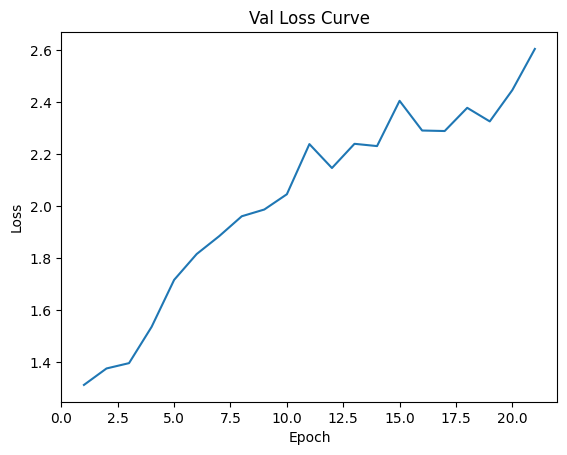

Finished Training Teacher for lambda val of 0
Teacher weights and architecture saved and exported for lambda: 0


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 1/300*****
*****Train Loss: -0.420925 Val Loss: -0.790608*****
*****Validation Accuracy: 58.73%*****
*****Total Avg Disparity: 0.17466050606036365*****

Class Team_Sports: Recall Difference = 0.03997197407602038
Class Celebration: Recall Difference = -0.11395348837209296
Class Parade: Recall Difference = 0.01123467351012264
Class Waiter_Or_Waitress: Recall Difference = -0.1470180305131762
Class Individual_Sports: Recall Difference = -0.06228229592609413
Class Surgeons: Recall Difference = -0.04582409460458253
Class Spa: Recall Difference = -0.6599999999999999
Class Law_Enforcement: Recall Difference = 0.08008008008008005
Class Business: Recall Difference = -0.07959031260002136
Class Dresses: Recall Difference = -0.538617886178862
Class Water_Activities: Recall Difference = 0.09783783783783784
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = -0.01822784810126582
Class Cheering: Recall Difference = 0.056398687448728446
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 2/300*****
*****Train Loss: -1.137864 Val Loss: -0.808554*****
*****Validation Accuracy: 62.68%*****
*****Total Avg Disparity: 0.20026220477641632*****

Class Team_Sports: Recall Difference = 0.05287557657499853
Class Celebration: Recall Difference = -0.044186046511627886
Class Parade: Recall Difference = 0.07927003136583965
Class Waiter_Or_Waitress: Recall Difference = 0.04160887656033285
Class Individual_Sports: Recall Difference = -0.140428593063759
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.86
Class Law_Enforcement: Recall Difference = 0.02902902902902904
Class Business: Recall Difference = -0.0918595967139656
Class Dresses: Recall Difference = -0.5887533875338754
Class Water_Activities: Recall Difference = 0.10583783783783784
Class Picnic: Recall Difference = -0.4181818181818183
Class Rescue: Recall Difference = 0.10303797468354431
Class Cheering: Recall Difference = -0.11033634126333058
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 3/300*****
*****Train Loss: -1.504683 Val Loss: -0.635533*****
*****Validation Accuracy: 61.53%*****
*****Total Avg Disparity: 0.17383834828715733*****

Class Team_Sports: Recall Difference = 0.050236468733578676
Class Celebration: Recall Difference = -0.19069767441860463
Class Parade: Recall Difference = 0.17074422583404625
Class Waiter_Or_Waitress: Recall Difference = -0.02542764678687015
Class Individual_Sports: Recall Difference = -0.11930183250037873
Class Surgeons: Recall Difference = -0.08795269770879538
Class Spa: Recall Difference = -0.5599999999999999
Class Law_Enforcement: Recall Difference = 0.16416416416416424
Class Business: Recall Difference = 0.023364984530032995
Class Dresses: Recall Difference = -0.61449864498645
Class Water_Activities: Recall Difference = 0.018378378378378524
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.13974683544303795
Class Cheering: Recall Difference = -0.00020508613617720162
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 4/300*****
*****Train Loss: -1.714417 Val Loss: -0.492868*****
*****Validation Accuracy: 59.19%*****
*****Total Avg Disparity: 0.15707105771070604*****

Class Team_Sports: Recall Difference = 0.03419162725521108
Class Celebration: Recall Difference = -0.17906976744186048
Class Parade: Recall Difference = 0.07003136583974912
Class Waiter_Or_Waitress: Recall Difference = 0.004623208506703613
Class Individual_Sports: Recall Difference = -0.0863622595789793
Class Surgeons: Recall Difference = -0.10643015521064297
Class Spa: Recall Difference = -0.5999999999999999
Class Law_Enforcement: Recall Difference = 0.13713713713713738
Class Business: Recall Difference = 0.017497066040755405
Class Dresses: Recall Difference = -0.6754742547425474
Class Water_Activities: Recall Difference = 0.06940540540540541
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = 0.06962025316455689
Class Cheering: Recall Difference = 0.02440525020508616
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 5/300*****
*****Train Loss: -1.847358 Val Loss: -0.438419*****
*****Validation Accuracy: 61.01%*****
*****Total Avg Disparity: 0.1749135023230563*****

Class Team_Sports: Recall Difference = 0.06051264085946173
Class Celebration: Recall Difference = -0.07209302325581396
Class Parade: Recall Difference = -0.000741374394068961
Class Waiter_Or_Waitress: Recall Difference = -0.09061488673139173
Class Individual_Sports: Recall Difference = -0.008632439800090652
Class Surgeons: Recall Difference = -0.14855875831485577
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.04954954954954971
Class Business: Recall Difference = -0.05686546463245501
Class Dresses: Recall Difference = -0.7181571815718157
Class Water_Activities: Recall Difference = 0.09232432432432436
Class Picnic: Recall Difference = -0.2363636363636364
Class Rescue: Recall Difference = 0.07443037974683547
Class Cheering: Recall Difference = -0.09803117309269888
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 6/300*****
*****Train Loss: -1.913720 Val Loss: -0.224733*****
*****Validation Accuracy: 61.39%*****
*****Total Avg Disparity: 0.14538409448373907*****

Class Team_Sports: Recall Difference = 0.10001751620248733
Class Celebration: Recall Difference = 0.039534883720930225
Class Parade: Recall Difference = 0.16122041631023665
Class Waiter_Or_Waitress: Recall Difference = -0.024503005085529383
Class Individual_Sports: Recall Difference = -0.0583068302286841
Class Surgeons: Recall Difference = -0.028085735402808565
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.034034034034034155
Class Business: Recall Difference = 0.04203563426864387
Class Dresses: Recall Difference = -0.5460704607046072
Class Water_Activities: Recall Difference = 0.10637837837837849
Class Picnic: Recall Difference = -0.10909090909090913
Class Rescue: Recall Difference = 0.03772151898734172
Class Cheering: Recall Difference = -0.07054963084495491
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 7/300*****
*****Train Loss: -1.947785 Val Loss: -0.216584*****
*****Validation Accuracy: 61.88%*****
*****Total Avg Disparity: 0.19955577591384044*****

Class Team_Sports: Recall Difference = 0.04541367431540844
Class Celebration: Recall Difference = 0.05813953488372098
Class Parade: Recall Difference = 0.024579412603364603
Class Waiter_Or_Waitress: Recall Difference = -0.12852519648636174
Class Individual_Sports: Recall Difference = -0.008821747690443638
Class Surgeons: Recall Difference = -0.07612712490761253
Class Spa: Recall Difference = -0.7599999999999999
Class Law_Enforcement: Recall Difference = 0.12187187187187187
Class Business: Recall Difference = -0.08417795796436572
Class Dresses: Recall Difference = -0.7012195121951219
Class Water_Activities: Recall Difference = 0.06583783783783781
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.01113924050632914
Class Cheering: Recall Difference = -0.17637407711238723
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 8/300*****
*****Train Loss: -1.952620 Val Loss: -0.121436*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.18707049081743454*****

Class Team_Sports: Recall Difference = 0.120277923746132
Class Celebration: Recall Difference = -0.018604651162790642
Class Parade: Recall Difference = 0.06592529227259769
Class Waiter_Or_Waitress: Recall Difference = -0.09153952843273239
Class Individual_Sports: Recall Difference = -0.08704376798424951
Class Surgeons: Recall Difference = 0.09386548410938655
Class Spa: Recall Difference = -0.62
Class Law_Enforcement: Recall Difference = 0.13163163163163166
Class Business: Recall Difference = -0.006508055051744399
Class Dresses: Recall Difference = -0.6571815718157181
Class Water_Activities: Recall Difference = 0.07935135135135152
Class Picnic: Recall Difference = -0.4181818181818182
Class Rescue: Recall Difference = 0.12911392405063296
Class Cheering: Recall Difference = -0.1031583264971288
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 9/300*****
*****Train Loss: -1.983044 Val Loss: -0.061378*****
*****Validation Accuracy: 62.05%*****
*****Total Avg Disparity: 0.17127363178914778*****

Class Team_Sports: Recall Difference = 0.06527704793600753
Class Celebration: Recall Difference = 0.0255813953488373
Class Parade: Recall Difference = -0.025491873396065068
Class Waiter_Or_Waitress: Recall Difference = -0.024503005085529383
Class Individual_Sports: Recall Difference = -0.11729516886263824
Class Surgeons: Recall Difference = -0.057649667405765104
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.11186186186186187
Class Business: Recall Difference = -0.04971727301824391
Class Dresses: Recall Difference = -0.7317073170731708
Class Water_Activities: Recall Difference = 0.11740540540540534
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.04101265822784811
Class Cheering: Recall Difference = -0.036505332239540556
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 10/300*****
*****Train Loss: -1.972093 Val Loss: -0.055300*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.1843058248275676*****

Class Team_Sports: Recall Difference = 0.10456005138086055
Class Celebration: Recall Difference = 0.016279069767441867
Class Parade: Recall Difference = 0.06649558026803526
Class Waiter_Or_Waitress: Recall Difference = 0.014331946370781279
Class Individual_Sports: Recall Difference = -0.06610631531122213
Class Surgeons: Recall Difference = -0.03399852180339996
Class Spa: Recall Difference = -0.7
Class Law_Enforcement: Recall Difference = 0.1501501501501501
Class Business: Recall Difference = -0.08161741171449904
Class Dresses: Recall Difference = -0.552168021680217
Class Water_Activities: Recall Difference = 0.11189189189189186
Class Picnic: Recall Difference = -0.43636363636363634
Class Rescue: Recall Difference = 0.15443037974683546
Class Cheering: Recall Difference = -0.06972928630024611
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 11/300*****
*****Train Loss: -2.006346 Val Loss:  0.032882*****
*****Validation Accuracy: 60.23%*****
*****Total Avg Disparity: 0.15989612290677196*****

Class Team_Sports: Recall Difference = 0.10175745898289235
Class Celebration: Recall Difference = -0.023255813953488302
Class Parade: Recall Difference = 0.04744796122041628
Class Waiter_Or_Waitress: Recall Difference = -0.012944983818770406
Class Individual_Sports: Recall Difference = -0.07553384825079501
Class Surgeons: Recall Difference = -0.08795269770879527
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.16541541541541538
Class Business: Recall Difference = -0.13325509442014294
Class Dresses: Recall Difference = -0.6131436314363145
Class Water_Activities: Recall Difference = 0.005945945945945996
Class Picnic: Recall Difference = -0.14545454545454556
Class Rescue: Recall Difference = -0.011645569620253204
Class Cheering: Recall Difference = 0.027276456111566816
Class Perfo

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 12/300*****
*****Train Loss: -2.023236 Val Loss: -0.037420*****
*****Validation Accuracy: 62.05%*****
*****Total Avg Disparity: 0.1862492373655395*****

Class Team_Sports: Recall Difference = 0.06729724995620945
Class Celebration: Recall Difference = -0.086046511627907
Class Parade: Recall Difference = 0.1010550327915598
Class Waiter_Or_Waitress: Recall Difference = -0.07212205270457706
Class Individual_Sports: Recall Difference = -0.05906406179009549
Class Surgeons: Recall Difference = -0.07612712490761264
Class Spa: Recall Difference = -0.7799999999999999
Class Law_Enforcement: Recall Difference = 0.1013513513513512
Class Business: Recall Difference = -0.058892563746932636
Class Dresses: Recall Difference = -0.7439024390243903
Class Water_Activities: Recall Difference = 0.0713513513513514
Class Picnic: Recall Difference = -0.29090909090909095
Class Rescue: Recall Difference = 0.11974683544303794
Class Cheering: Recall Difference = 0.057013945857259996
Class Performance_And

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 13/300*****
*****Train Loss: -2.005547 Val Loss:  0.066215*****
*****Validation Accuracy: 59.91%*****
*****Total Avg Disparity: 0.20623480730679*****

Class Team_Sports: Recall Difference = 0.0555146844164186
Class Celebration: Recall Difference = 0.06511627906976736
Class Parade: Recall Difference = -0.08999144568006856
Class Waiter_Or_Waitress: Recall Difference = -0.03143781784558497
Class Individual_Sports: Recall Difference = -0.06353172800242313
Class Surgeons: Recall Difference = -0.009608277900960804
Class Spa: Recall Difference = -0.7999999999999999
Class Law_Enforcement: Recall Difference = 0.25300300300300316
Class Business: Recall Difference = -0.12098581030619865
Class Dresses: Recall Difference = -0.7181571815718157
Class Water_Activities: Recall Difference = 0.05481081081081085
Class Picnic: Recall Difference = -0.4363636363636364
Class Rescue: Recall Difference = 0.022531645569620257
Class Cheering: Recall Difference = 0.02522559474979491
Class Performance_An

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 14/300*****
*****Train Loss: -2.014207 Val Loss:  0.120650*****
*****Validation Accuracy: 60.06%*****
*****Total Avg Disparity: 0.17559067565266312*****

Class Team_Sports: Recall Difference = 0.0635371051556024
Class Celebration: Recall Difference = -0.03023255813953485
Class Parade: Recall Difference = 0.1160536070715712
Class Waiter_Or_Waitress: Recall Difference = 0.004623208506703502
Class Individual_Sports: Recall Difference = -0.1061638649098895
Class Surgeons: Recall Difference = 0.06282335550628232
Class Spa: Recall Difference = -0.6599999999999999
Class Law_Enforcement: Recall Difference = 0.09984984984985001
Class Business: Recall Difference = -0.01675024005121095
Class Dresses: Recall Difference = -0.6646341463414634
Class Water_Activities: Recall Difference = 0.054270270270270315
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.13974683544303793
Class Cheering: Recall Difference = -0.06972928630024605
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 15/300*****
*****Train Loss: -2.037929 Val Loss:  0.281143*****
*****Validation Accuracy: 59.71%*****
*****Total Avg Disparity: 0.1864408808267249*****

Class Team_Sports: Recall Difference = 0.09041863723944643
Class Celebration: Recall Difference = -0.11395348837209296
Class Parade: Recall Difference = 0.0654690618762474
Class Waiter_Or_Waitress: Recall Difference = -0.1294498381877024
Class Individual_Sports: Recall Difference = -0.10245343025897324
Class Surgeons: Recall Difference = -0.09386548410938655
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.13213213213213226
Class Business: Recall Difference = -0.12023898431665425
Class Dresses: Recall Difference = -0.4607046070460705
Class Water_Activities: Recall Difference = 0.16486486486486496
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.014430379746835476
Class Cheering: Recall Difference = -0.08429040196882692
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 16/300*****
*****Train Loss: -2.045628 Val Loss:  0.202035*****
*****Validation Accuracy: 61.47%*****
*****Total Avg Disparity: 0.18035025305355756*****

Class Team_Sports: Recall Difference = 0.0782390377766099
Class Celebration: Recall Difference = -0.0906976744186046
Class Parade: Recall Difference = 0.13863701169090414
Class Waiter_Or_Waitress: Recall Difference = -0.04299583911234406
Class Individual_Sports: Recall Difference = -0.12005906406179012
Class Surgeons: Recall Difference = -0.057649667405765104
Class Spa: Recall Difference = -0.6399999999999999
Class Law_Enforcement: Recall Difference = 0.04429429429429421
Class Business: Recall Difference = -0.04331590739357727
Class Dresses: Recall Difference = -0.6815718157181574
Class Water_Activities: Recall Difference = 0.09340540540540543
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = 0.05316455696202527
Class Cheering: Recall Difference = -0.14376538146021328
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 17/300*****
*****Train Loss: -2.012903 Val Loss:  0.116148*****
*****Validation Accuracy: 60.66%*****
*****Total Avg Disparity: 0.18959167648861483*****

Class Team_Sports: Recall Difference = 0.042832953815612806
Class Celebration: Recall Difference = 0.07441860465116273
Class Parade: Recall Difference = 0.04471057884231544
Class Waiter_Or_Waitress: Recall Difference = -0.021729079981507304
Class Individual_Sports: Recall Difference = -0.11578070573981525
Class Surgeons: Recall Difference = 0.11751662971175164
Class Spa: Recall Difference = -0.6399999999999999
Class Law_Enforcement: Recall Difference = 0.09459459459459463
Class Business: Recall Difference = -0.10284860770297666
Class Dresses: Recall Difference = -0.6998644986449865
Class Water_Activities: Recall Difference = 0.10637837837837838
Class Picnic: Recall Difference = -0.4363636363636364
Class Rescue: Recall Difference = 0.031139240506329047
Class Cheering: Recall Difference = -0.04224774405250209
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 18/300*****
*****Train Loss: -2.011657 Val Loss:  0.151034*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.19431356044978282*****

Class Team_Sports: Recall Difference = 0.042155660652770655
Class Celebration: Recall Difference = 0.05116279069767443
Class Parade: Recall Difference = -0.012147134302822882
Class Waiter_Or_Waitress: Recall Difference = -0.014794267221451718
Class Individual_Sports: Recall Difference = -0.12301226715129465
Class Surgeons: Recall Difference = -0.08203991130820398
Class Spa: Recall Difference = -0.6399999999999999
Class Law_Enforcement: Recall Difference = 0.12312312312312307
Class Business: Recall Difference = -0.0737223941107436
Class Dresses: Recall Difference = -0.7804878048780488
Class Water_Activities: Recall Difference = 0.08432432432432413
Class Picnic: Recall Difference = -0.509090909090909
Class Rescue: Recall Difference = 0.1356962025316456
Class Cheering: Recall Difference = -0.07424118129614443
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 19/300*****
*****Train Loss: -2.019995 Val Loss:  0.143666*****
*****Validation Accuracy: 60.38%*****
*****Total Avg Disparity: 0.15892397463606842*****

Class Team_Sports: Recall Difference = 0.1051789572020786
Class Celebration: Recall Difference = 0.020930232558139583
Class Parade: Recall Difference = -0.03011120615911045
Class Waiter_Or_Waitress: Recall Difference = 0.006472491909384925
Class Individual_Sports: Recall Difference = -0.031841587157352635
Class Surgeons: Recall Difference = -0.08203991130820415
Class Spa: Recall Difference = -0.7
Class Law_Enforcement: Recall Difference = 0.07132132132132141
Class Business: Recall Difference = -0.009068601301611079
Class Dresses: Recall Difference = -0.6951219512195123
Class Water_Activities: Recall Difference = 0.09340540540540543
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.035696202531645516
Class Cheering: Recall Difference = -0.10459392945036916
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 20/300*****
*****Train Loss: -2.020659 Val Loss:  0.171940*****
*****Validation Accuracy: 61.82%*****
*****Total Avg Disparity: 0.1791125626259923*****

Class Team_Sports: Recall Difference = 0.06179716237519717
Class Celebration: Recall Difference = -0.06279069767441858
Class Parade: Recall Difference = 0.014257199885942318
Class Waiter_Or_Waitress: Recall Difference = 0.014331946370781279
Class Individual_Sports: Recall Difference = -0.13338633954263213
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.6399999999999999
Class Law_Enforcement: Recall Difference = 0.14214214214214227
Class Business: Recall Difference = -0.08471140509975461
Class Dresses: Recall Difference = -0.6571815718157181
Class Water_Activities: Recall Difference = 0.060864864864864976
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.043544303797468376
Class Cheering: Recall Difference = -0.06480721903199343
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 21/300*****
*****Train Loss: -2.060841 Val Loss:  0.267236*****
*****Validation Accuracy: 62.83%*****
*****Total Avg Disparity: 0.1507214421552175*****

Class Team_Sports: Recall Difference = 0.0903602498978221
Class Celebration: Recall Difference = 0.016279069767441867
Class Parade: Recall Difference = 0.03028229255774173
Class Waiter_Or_Waitress: Recall Difference = -0.05362921867776238
Class Individual_Sports: Recall Difference = -0.10835983643798275
Class Surgeons: Recall Difference = -0.02734663710273455
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.08133133133133141
Class Business: Recall Difference = -0.1281340019204097
Class Dresses: Recall Difference = -0.6388888888888891
Class Water_Activities: Recall Difference = 0.044324324324324316
Class Picnic: Recall Difference = -0.10909090909090907
Class Rescue: Recall Difference = 0.07645569620253165
Class Cheering: Recall Difference = -0.06993437243642331
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 22/300*****
*****Train Loss: -2.073835 Val Loss:  0.282600*****
*****Validation Accuracy: 61.07%*****
*****Total Avg Disparity: 0.16159149608609144*****

Class Team_Sports: Recall Difference = 0.12740117942430085
Class Celebration: Recall Difference = 0.023255813953488358
Class Parade: Recall Difference = 0.034388366124893044
Class Waiter_Or_Waitress: Recall Difference = -0.021729079981507304
Class Individual_Sports: Recall Difference = -0.11578070573981525
Class Surgeons: Recall Difference = -0.0761271249076127
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.07782782782782793
Class Business: Recall Difference = -0.10284860770297666
Class Dresses: Recall Difference = -0.6585365853658537
Class Water_Activities: Recall Difference = 0.1303783783783784
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = 0.12101265822784812
Class Cheering: Recall Difference = -0.1017227235438885
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 23/300*****
*****Train Loss: -2.046932 Val Loss:  0.289775*****
*****Validation Accuracy: 58.96%*****
*****Total Avg Disparity: 0.17343753440462534*****

Class Team_Sports: Recall Difference = 0.06679511881824018
Class Celebration: Recall Difference = -0.08837209302325583
Class Parade: Recall Difference = -0.003992015968063756
Class Waiter_Or_Waitress: Recall Difference = -0.10032362459546929
Class Individual_Sports: Recall Difference = -0.07038467363319723
Class Surgeons: Recall Difference = 0.03917220990391723
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.0745745745745745
Class Business: Recall Difference = -0.14296383228422066
Class Dresses: Recall Difference = -0.725609756097561
Class Water_Activities: Recall Difference = 0.12486486486486492
Class Picnic: Recall Difference = -0.5454545454545455
Class Rescue: Recall Difference = -0.050886075949367005
Class Cheering: Recall Difference = 0.05045118949958988
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 24/300*****
*****Train Loss: -2.038162 Val Loss:  0.385184*****
*****Validation Accuracy: 58.96%*****
*****Total Avg Disparity: 0.15951746232033925*****

Class Team_Sports: Recall Difference = 0.08895895369883788
Class Celebration: Recall Difference = -0.0720930232558139
Class Parade: Recall Difference = -0.008611348731109136
Class Waiter_Or_Waitress: Recall Difference = -0.1266759130836801
Class Individual_Sports: Recall Difference = -0.085226412236862
Class Surgeons: Recall Difference = -0.03917220990391712
Class Spa: Recall Difference = -0.6000000000000001
Class Law_Enforcement: Recall Difference = 0.19919919919919932
Class Business: Recall Difference = -0.18051851061559787
Class Dresses: Recall Difference = -0.44105691056910573
Class Water_Activities: Recall Difference = 0.07189189189189193
Class Picnic: Recall Difference = -0.03636363636363643
Class Rescue: Recall Difference = 0.14177215189873416
Class Cheering: Recall Difference = 0.012920426579163258
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 25/300*****
*****Train Loss: -2.013146 Val Loss:  0.389015*****
*****Validation Accuracy: 59.57%*****
*****Total Avg Disparity: 0.17511529076804377*****

Class Team_Sports: Recall Difference = 0.12431832778653595
Class Celebration: Recall Difference = 0.006976744186046546
Class Parade: Recall Difference = 0.04716281722269733
Class Waiter_Or_Waitress: Recall Difference = 0.05316689782709194
Class Individual_Sports: Recall Difference = -0.06239588066030599
Class Surgeons: Recall Difference = -0.17368810051736877
Class Spa: Recall Difference = -0.6200000000000001
Class Law_Enforcement: Recall Difference = 0.09809809809809811
Class Business: Recall Difference = -0.07574949322522134
Class Dresses: Recall Difference = -0.7378048780487805
Class Water_Activities: Recall Difference = 0.10691891891891891
Class Picnic: Recall Difference = -0.2545454545454546
Class Rescue: Recall Difference = 0.1124050632911392
Class Cheering: Recall Difference = -0.06624282198523379
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 26/300*****
*****Train Loss: -2.038816 Val Loss:  0.303722*****
*****Validation Accuracy: 59.71%*****
*****Total Avg Disparity: 0.1879601301185611*****

Class Team_Sports: Recall Difference = 0.05669410871723013
Class Celebration: Recall Difference = -0.06279069767441864
Class Parade: Recall Difference = 0.05178214998574282
Class Waiter_Or_Waitress: Recall Difference = 0.024040684234858833
Class Individual_Sports: Recall Difference = -0.06372103589277589
Class Surgeons: Recall Difference = -0.033998521803399795
Class Spa: Recall Difference = -0.7599999999999999
Class Law_Enforcement: Recall Difference = 0.10810810810810811
Class Business: Recall Difference = -0.0859916782246879
Class Dresses: Recall Difference = -0.6402439024390244
Class Water_Activities: Recall Difference = 0.12486486486486503
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.00354430379746834
Class Cheering: Recall Difference = -0.09228876127973751
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 27/300*****
*****Train Loss: -2.034234 Val Loss:  0.374111*****
*****Validation Accuracy: 59.83%*****
*****Total Avg Disparity: 0.16495036923584783*****

Class Team_Sports: Recall Difference = 0.04905704443276704
Class Celebration: Recall Difference = -0.027906976744186074
Class Parade: Recall Difference = 0.050983746792130025
Class Waiter_Or_Waitress: Recall Difference = 0.12020342117429472
Class Individual_Sports: Recall Difference = -0.07133121308496149
Class Surgeons: Recall Difference = -0.11899482631189945
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.0915915915915918
Class Business: Recall Difference = -0.08855222447455469
Class Dresses: Recall Difference = -0.44241192411924113
Class Water_Activities: Recall Difference = 0.13891891891891883
Class Picnic: Recall Difference = -0.16363636363636375
Class Rescue: Recall Difference = 0.11645569620253157
Class Cheering: Recall Difference = -0.0750615258408531
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 28/300*****
*****Train Loss: -2.067253 Val Loss:  0.408685*****
*****Validation Accuracy: 59.19%*****
*****Total Avg Disparity: 0.170406710803029*****

Class Team_Sports: Recall Difference = 0.07117416944006538
Class Celebration: Recall Difference = 0.023255813953488413
Class Parade: Recall Difference = -0.0020530367835758234
Class Waiter_Or_Waitress: Recall Difference = -0.03236245954692574
Class Individual_Sports: Recall Difference = -0.05440708768741476
Class Surgeons: Recall Difference = -0.05838876570583884
Class Spa: Recall Difference = -0.58
Class Law_Enforcement: Recall Difference = 0.06281281281281281
Class Business: Recall Difference = -0.09698068921369901
Class Dresses: Recall Difference = -0.6388888888888891
Class Water_Activities: Recall Difference = 0.16400000000000003
Class Picnic: Recall Difference = -0.36363636363636376
Class Rescue: Recall Difference = 0.0017721518987341423
Class Cheering: Recall Difference = -0.19298605414273995
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 29/300*****
*****Train Loss: -2.054683 Val Loss:  0.246570*****
*****Validation Accuracy: 60.72%*****
*****Total Avg Disparity: 0.15341218984882143*****

Class Team_Sports: Recall Difference = 0.05399661353418572
Class Celebration: Recall Difference = 0.018604651162790697
Class Parade: Recall Difference = 0.0763045337895637
Class Waiter_Or_Waitress: Recall Difference = -0.06056403143781797
Class Individual_Sports: Recall Difference = -0.18029683477207337
Class Surgeons: Recall Difference = -0.009608277900960749
Class Spa: Recall Difference = -0.5399999999999999
Class Law_Enforcement: Recall Difference = 0.10310310310310311
Class Business: Recall Difference = -0.05889256374693275
Class Dresses: Recall Difference = -0.7439024390243903
Class Water_Activities: Recall Difference = 0.1168648648648648
Class Picnic: Recall Difference = -0.07272727272727281
Class Rescue: Recall Difference = -0.009620253164557058
Class Cheering: Recall Difference = -0.05250205086136178
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 30/300*****
*****Train Loss: -2.069347 Val Loss:  0.380810*****
*****Validation Accuracy: 60.55%*****
*****Total Avg Disparity: 0.17198220090076863*****

Class Team_Sports: Recall Difference = 0.07975710865884267
Class Celebration: Recall Difference = 0.09302325581395349
Class Parade: Recall Difference = 0.058055317935557516
Class Waiter_Or_Waitress: Recall Difference = -0.04022191400832176
Class Individual_Sports: Recall Difference = -0.08000151446312276
Class Surgeons: Recall Difference = -0.11308203991130816
Class Spa: Recall Difference = -0.84
Class Law_Enforcement: Recall Difference = 0.04404404404404416
Class Business: Recall Difference = -0.11511789181692095
Class Dresses: Recall Difference = -0.7378048780487805
Class Water_Activities: Recall Difference = 0.09589189189189207
Class Picnic: Recall Difference = -0.12727272727272726
Class Rescue: Recall Difference = 0.03443037974683544
Class Cheering: Recall Difference = -0.02707136997538967
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 31/300*****
*****Train Loss: -2.064860 Val Loss:  0.428899*****
*****Validation Accuracy: 60.49%*****
*****Total Avg Disparity: 0.17813056645983033*****

Class Team_Sports: Recall Difference = 0.12167921994511588
Class Celebration: Recall Difference = -0.12558139534883722
Class Parade: Recall Difference = 0.06244653550042778
Class Waiter_Or_Waitress: Recall Difference = 0.08136846971798417
Class Individual_Sports: Recall Difference = -0.10074965924579726
Class Surgeons: Recall Difference = -0.18551367331855134
Class Spa: Recall Difference = -0.6599999999999999
Class Law_Enforcement: Recall Difference = 0.022272272272272353
Class Business: Recall Difference = -0.1383761869198763
Class Dresses: Recall Difference = -0.7195121951219512
Class Water_Activities: Recall Difference = 0.11491891891891892
Class Picnic: Recall Difference = -0.10909090909090907
Class Rescue: Recall Difference = 0.08177215189873416
Class Cheering: Recall Difference = -0.01538146021328951
Class Performance

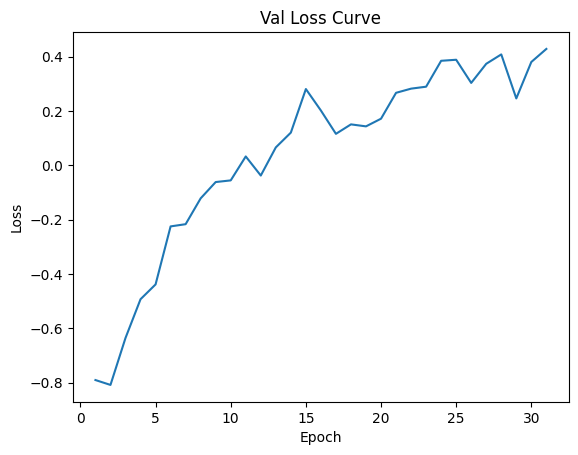

Finished Training Teacher for lambda val of 4
Teacher weights and architecture saved and exported for lambda: 4


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 1/300*****
*****Train Loss: -1.896112 Val Loss: -2.743863*****
*****Validation Accuracy: 61.10%*****
*****Total Avg Disparity: 0.17201121218695434*****

Class Team_Sports: Recall Difference = 0.09496117241781965
Class Celebration: Recall Difference = 0.1
Class Parade: Recall Difference = 0.048531508411748026
Class Waiter_Or_Waitress: Recall Difference = -0.024503005085529383
Class Individual_Sports: Recall Difference = -0.25223383310616376
Class Surgeons: Recall Difference = -0.033259423503326
Class Spa: Recall Difference = -0.86
Class Law_Enforcement: Recall Difference = 0.2127127127127128
Class Business: Recall Difference = -0.08855222447455469
Class Dresses: Recall Difference = -0.3556910569105693
Class Water_Activities: Recall Difference = 0.15135135135135147
Class Picnic: Recall Difference = -0.2
Class Rescue: Recall Difference = 0.07113924050632908
Class Cheering: Recall Difference = -0.041632485643970485
Class Performance_And_Entertainment: Recall Difference = 0.02427

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 2/300*****
*****Train Loss: -3.247417 Val Loss: -2.926942*****
*****Validation Accuracy: 62.02%*****
*****Total Avg Disparity: 0.1914229100283546*****

Class Team_Sports: Recall Difference = 0.12078005488410104
Class Celebration: Recall Difference = 0.018604651162790753
Class Parade: Recall Difference = 0.08691189050470483
Class Waiter_Or_Waitress: Recall Difference = -0.12066574202496538
Class Individual_Sports: Recall Difference = -0.06220657276995312
Class Surgeons: Recall Difference = -0.1359940872135993
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.16216216216216212
Class Business: Recall Difference = -0.03158007041502198
Class Dresses: Recall Difference = -0.61449864498645
Class Water_Activities: Recall Difference = 0.14140540540540547
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.05645569620253166
Class Cheering: Recall Difference = -0.06931911402789173
Class Performance_And_Entertainment: Recall Differe

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 3/300*****
*****Train Loss: -3.799916 Val Loss: -3.086996*****
*****Validation Accuracy: 60.63%*****
*****Total Avg Disparity: 0.18106972248012815*****

Class Team_Sports: Recall Difference = 0.11617913236410349
Class Celebration: Recall Difference = -0.03023255813953485
Class Parade: Recall Difference = 0.06432848588537221
Class Waiter_Or_Waitress: Recall Difference = -0.15765141007859462
Class Individual_Sports: Recall Difference = -0.09836437982735113
Class Surgeons: Recall Difference = -0.11825572801182566
Class Spa: Recall Difference = -0.84
Class Law_Enforcement: Recall Difference = 0.14039039039039058
Class Business: Recall Difference = -0.1532060172836872
Class Dresses: Recall Difference = -0.40447154471544716
Class Water_Activities: Recall Difference = 0.060864864864864865
Class Picnic: Recall Difference = -0.2545454545454546
Class Rescue: Recall Difference = 0.0870886075949367
Class Cheering: Recall Difference = -0.005947497949138625
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 4/300*****
*****Train Loss: -4.192141 Val Loss: -2.998331*****
*****Validation Accuracy: 61.96%*****
*****Total Avg Disparity: 0.13819485799678982*****

Class Team_Sports: Recall Difference = 0.1126408594616688
Class Celebration: Recall Difference = -0.0255813953488373
Class Parade: Recall Difference = 0.043341887653264966
Class Waiter_Or_Waitress: Recall Difference = -0.08183079056865483
Class Individual_Sports: Recall Difference = -0.04497955474784199
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.7799999999999999
Class Law_Enforcement: Recall Difference = 0.05105105105105112
Class Business: Recall Difference = 0.005227781926811059
Class Dresses: Recall Difference = -0.3787262872628727
Class Water_Activities: Recall Difference = 0.06389189189189204
Class Picnic: Recall Difference = 0.19999999999999996
Class Rescue: Recall Difference = -0.020253164556962022
Class Cheering: Recall Difference = -0.05332239540607056
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 5/300*****
*****Train Loss: -4.455123 Val Loss: -3.266592*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.14280349401009584*****

Class Team_Sports: Recall Difference = 0.07801716587843732
Class Celebration: Recall Difference = 0.0023255813953488857
Class Parade: Recall Difference = 0.032221271742229884
Class Waiter_Or_Waitress: Recall Difference = -0.0684234858992141
Class Individual_Sports: Recall Difference = -0.07629107981220673
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.6199999999999999
Class Law_Enforcement: Recall Difference = 0.07607607607607614
Class Business: Recall Difference = -0.04640990077883289
Class Dresses: Recall Difference = -0.6205962059620596
Class Water_Activities: Recall Difference = 0.12486486486486503
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = 0.027088607594936698
Class Cheering: Recall Difference = -0.06685808039376534
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 6/300*****
*****Train Loss: -4.813752 Val Loss: -3.171221*****
*****Validation Accuracy: 60.26%*****
*****Total Avg Disparity: 0.17620609829376754*****

Class Team_Sports: Recall Difference = 0.07919659017924918
Class Celebration: Recall Difference = -0.004651162790697716
Class Parade: Recall Difference = 0.03330481893356152
Class Waiter_Or_Waitress: Recall Difference = -0.19463707813222375
Class Individual_Sports: Recall Difference = -0.04259427532939575
Class Surgeons: Recall Difference = -0.12342941611234293
Class Spa: Recall Difference = -0.66
Class Law_Enforcement: Recall Difference = 0.06781781781781782
Class Business: Recall Difference = -0.05377147124719939
Class Dresses: Recall Difference = -0.6951219512195121
Class Water_Activities: Recall Difference = 0.10940540540540544
Class Picnic: Recall Difference = -0.1272727272727273
Class Rescue: Recall Difference = 0.1316455696202532
Class Cheering: Recall Difference = -0.10664479081214107
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 7/300*****
*****Train Loss: -5.012778 Val Loss: -3.188039*****
*****Validation Accuracy: 60.06%*****
*****Total Avg Disparity: 0.13707420424930722*****

Class Team_Sports: Recall Difference = 0.11034039820166985
Class Celebration: Recall Difference = 0.0023255813953487747
Class Parade: Recall Difference = -0.007527801539777501
Class Waiter_Or_Waitress: Recall Difference = -0.14516874711049466
Class Individual_Sports: Recall Difference = -0.09560048462819937
Class Surgeons: Recall Difference = 0.028085735402808676
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.14539539539539548
Class Business: Recall Difference = -0.08161741171449904
Class Dresses: Recall Difference = -0.4789972899728998
Class Water_Activities: Recall Difference = 0.055351351351351386
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = 0.04506329113924051
Class Cheering: Recall Difference = -0.023379819524200207
Class Performance_And_Ente

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 8/300*****
*****Train Loss: -4.995815 Val Loss: -3.016782*****
*****Validation Accuracy: 59.42%*****
*****Total Avg Disparity: 0.15708093807831566*****

Class Team_Sports: Recall Difference = 0.06809131780230038
Class Celebration: Recall Difference = -0.08372093023255817
Class Parade: Recall Difference = 0.0667807242657541
Class Waiter_Or_Waitress: Recall Difference = 0.003698566805362846
Class Individual_Sports: Recall Difference = -0.036612145994245116
Class Surgeons: Recall Difference = -0.12416851441241672
Class Spa: Recall Difference = -0.82
Class Law_Enforcement: Recall Difference = 0.092842842842843
Class Business: Recall Difference = -0.05430491838258822
Class Dresses: Recall Difference = -0.6158536585365852
Class Water_Activities: Recall Difference = 0.09037837837837848
Class Picnic: Recall Difference = 0.05454545454545445
Class Rescue: Recall Difference = 0.06506329113924048
Class Cheering: Recall Difference = -0.018252666119770278
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 9/300*****
*****Train Loss: -5.053150 Val Loss: -3.071377*****
*****Validation Accuracy: 61.18%*****
*****Total Avg Disparity: 0.17791165986404725*****

Class Team_Sports: Recall Difference = 0.1010801658200502
Class Celebration: Recall Difference = 0.07209302325581385
Class Parade: Recall Difference = 0.019389791844881765
Class Waiter_Or_Waitress: Recall Difference = -0.2829403606102636
Class Individual_Sports: Recall Difference = 0.0009844010298348804
Class Surgeons: Recall Difference = -0.1367331855136732
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.10835835835835839
Class Business: Recall Difference = -0.085991678224688
Class Dresses: Recall Difference = -0.628048780487805
Class Water_Activities: Recall Difference = 0.06886486486486498
Class Picnic: Recall Difference = -0.10909090909090907
Class Rescue: Recall Difference = 0.10835443037974679
Class Cheering: Recall Difference = -0.13084495488105
Class Performance_And_Entertainment: Re

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 10/300*****
*****Train Loss: -5.068902 Val Loss: -3.255795*****
*****Validation Accuracy: 61.70%*****
*****Total Avg Disparity: 0.18777468788358292*****

Class Team_Sports: Recall Difference = 0.12251999766450639
Class Celebration: Recall Difference = -0.06976744186046518
Class Parade: Recall Difference = -0.006444254348445977
Class Waiter_Or_Waitress: Recall Difference = -0.14008321775312083
Class Individual_Sports: Recall Difference = -0.09132212630622438
Class Surgeons: Recall Difference = 0.08795269770879532
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.16391391391391397
Class Business: Recall Difference = -0.12685372879547635
Class Dresses: Recall Difference = -0.7743902439024392
Class Water_Activities: Recall Difference = 0.08043243243243248
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = 0.06506329113924048
Class Cheering: Recall Difference = -0.0022559474979491623
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 11/300*****
*****Train Loss: -5.044567 Val Loss: -3.042286*****
*****Validation Accuracy: 61.15%*****
*****Total Avg Disparity: 0.16577235421995984*****

Class Team_Sports: Recall Difference = 0.08985811875985272
Class Celebration: Recall Difference = -0.03720930232558145
Class Parade: Recall Difference = 0.0651268890789849
Class Waiter_Or_Waitress: Recall Difference = -0.1761442441054092
Class Individual_Sports: Recall Difference = -0.07742692715432375
Class Surgeons: Recall Difference = 0.02734663710273466
Class Spa: Recall Difference = -0.7799999999999999
Class Law_Enforcement: Recall Difference = 0.10985985985985991
Class Business: Recall Difference = -0.05761229062199941
Class Dresses: Recall Difference = -0.6084010840108403
Class Water_Activities: Recall Difference = 0.07632432432432434
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = 0.013164556962025259
Class Cheering: Recall Difference = -0.11771944216570962
Class Performance

 73%|█████████████████████████████████████████████████████▌                   | 119/162 [01:21<00:28,  1.48it/s]

In [ ]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state to the 'output_dir'
    teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model.state_dict(), teacher_model_weights_path)
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, teacher_model_path)
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


In [ ]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model_path = os.path.join(output_dir, 'teacher_model_ckd_wider_lambda0.pth')
    teacher_model = torch.load(teacher_model_path)
    teacher_model_weights_path = os.path.join(output_dir, 'teacher_model_weights_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load(teacher_model_weights_path))
    teacher_model = teacher_model.to(device)
    
    # # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)
    
    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    # Save the student model's state dictionary to the 'output_dir'
    student_model_weights_path = os.path.join(output_dir, f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model.state_dict(), student_model_weights_path)
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{i}.pth')
    torch.save(student_model, student_model_path)

    print('Student weights and architecture saved and exported for lambda:', i)

    # Check if the key exists in the dictionary
    if i not in lambda_results:
        # If not, create a new entry for that key
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }
    else:
        # If the key exists, update the existing entry
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })


In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [ ]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Prepare data for plotting
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = round(data['actual_attribute'], 2)  # Round to 2 decimal places

            # Normalize the image for display
            image_display = image.cpu().numpy().transpose(1, 2, 0)
            image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image_display)
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [ ]:
teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda0.pth')
teacher_model = torch.load(teacher_model_path)
student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda8.pth')
student_model = torch.load(student_model_path)

# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)